In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from __future__ import division

In [2]:
dataset = pd.read_csv("train.csv") 
raw_dataset = dataset.copy()

### explore

In [3]:
dataset.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [4]:
len(dataset)

371

In [5]:
dataset.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [6]:
print 'colors ->', dataset['color'].unique()
print 'types ->', dataset['type'].unique()

colors -> ['clear' 'green' 'black' 'white' 'blue' 'blood']
types -> ['Ghoul' 'Goblin' 'Ghost']


In [7]:
dataset.isnull().sum() # no missing values

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64

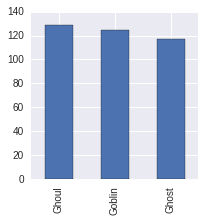

In [8]:
dataset.type.value_counts().plot(kind='bar', figsize=(3,3))

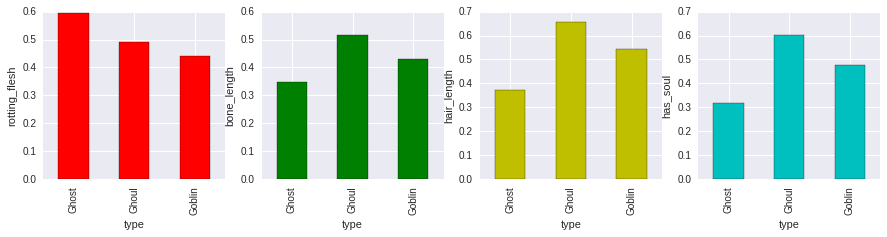

In [9]:
colors  = ['r', 'g', 'y', 'c']
columns = ['rotting_flesh', 'bone_length', 'hair_length', 'has_soul']

for i in range(len(columns)):
    plt.subplot(1,4,i+1)
    column = columns[i]
    col = colors[i]
    column_means = dataset.groupby('type').mean()[column] # means by column
    column_means.plot(kind='bar',figsize=(15,3), color=col).set_ylabel(column)

### drop useless columns & hot-encode colors

In [10]:
dataset = dataset.drop('id', axis=1)

In [11]:
dataset_x = dataset.drop('type', axis=1)
dataset_x = pd.get_dummies(dataset_x)

dataset_y = dataset['type']

In [12]:
dataset_x.head()

,bone_length,rotting_flesh,hair_length,has_soul,color_black,color_blood,color_blue,color_clear,color_green,color_white
0,0.354512,0.350839,0.465761,0.781142,0,0,0,1,0,0
1,0.575560,0.425868,0.531401,0.439899,0,0,0,0,1,0
2,0.467875,0.354330,0.811616,0.791225,1,0,0,0,0,0
3,0.776652,0.508723,0.636766,0.884464,1,0,0,0,0,0
4,0.566117,0.875862,0.418594,0.636438,0,0,0,0,1,0


### train simple model

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

simple_log_reg = LogisticRegression()
print 'accuracy', cross_validation.cross_val_score(simple_log_reg, dataset_x, dataset_y, cv=4).mean()
print
for label, strength in zip(list(dataset_x), sum(np.absolute(simple_log_reg.fit(dataset_x, dataset_y).coef_)) / 3 ):
    print label, '-->', strength

accuracy 0.684467963387

bone_length --> 1.7408991426
rotting_flesh --> 2.52449393785
hair_length --> 2.61996757837
has_soul --> 2.44121249361
color_black --> 0.315596375898
color_blood --> 0.582285736606
color_blue --> 0.391915312419
color_clear --> 0.455205703878
color_green --> 0.394776344175
color_white --> 0.27230286957


/home/mariusz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### remove weak predictors

In [14]:
dataset_x_all = dataset_x
dataset_x = dataset_x[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']]

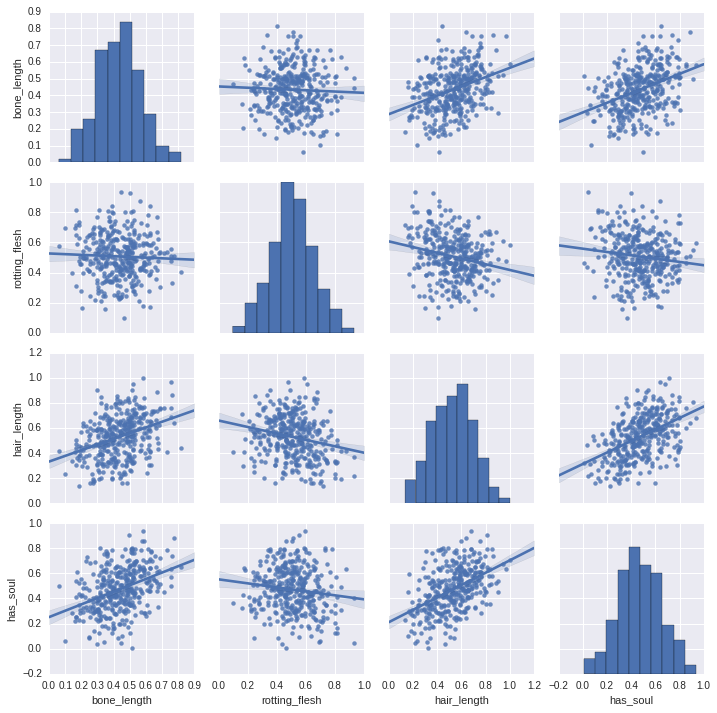

In [15]:
sns.pairplot(dataset_x, kind="reg")

### trying out different algorithms

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

log_reg = LogisticRegression()
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
dec_tree = tree.DecisionTreeClassifier()
forest = RandomForestClassifier()
svc = svm.SVC()

algos = {
    'log_reg':     log_reg, 
    'knn':         knn, 
    'naive_bayes': naive_bayes, 
    'dec_tree':    dec_tree,
    'forest':      forest,
    'svc':         svc
}

for name, algo in algos.iteritems():
    print name, '-->', str(cross_validation.cross_val_score(algo, dataset_x, dataset_y, cv=4).mean())[:4]


knn --> 0.71
svc --> 0.75
log_reg --> 0.69
forest --> 0.70
dec_tree --> 0.64
naive_bayes --> 0.74


### bagging naive bayes

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

bag = BaggingClassifier(GaussianNB())

parameter_grid = {'n_estimators': [10, 30, 50, 100, 200],
                  'warm_start':   [True, False]}

grid_search = GridSearchCV(bag, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(dataset_x, dataset_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.746630727763
Best parameters: {'n_estimators': 50, 'warm_start': False}


### random_forests

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

parameter_grid = {'n_estimators':      [15, 100, 200],
                  'criterion':         ['gini', 'entropy'],
                  'min_samples_split': [5, 6],
                  'max_features':      ['auto', 'sqrt', 'log2', None],
                  'class_weight':      ['balanced', None]}

rf_grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
rf_grid_search.fit(dataset_x, dataset_y)
rf_best = rf_grid_search.best_estimator_
print 'Best score: {}'.format(rf_grid_search.best_score_)
print 'Best parameters: {}'.format(rf_grid_search.best_params_)


Best score: 0.738544474394
Best parameters: {'max_features': 'auto', 'min_samples_split': 6, 'n_estimators': 15, 'criterion': 'gini', 'class_weight': 'balanced'}


### log_reg

In [19]:
parameter_grid = {'C':            [0.005, 0.01, 1, 10, 100, 1000],
                  'multi_class' : ['ovr', 'multinomial'],
                  'solver':       ['newton-cg', 'lbfgs'],
                  'tol':          [ 1e-3, 1e-4, 1e-5]}

lr_grid_search = GridSearchCV(log_reg, param_grid=parameter_grid, cv=StratifiedKFold(4))
lr_grid_search.fit(dataset_x, dataset_y)
lr_best = lr_grid_search.best_estimator_
print('Best score: {}'.format(lr_grid_search.best_score_))
print('Best parameters: {}'.format(lr_grid_search.best_params_))

Best score: 0.760107816712
Best parameters: {'multi_class': 'multinomial', 'C': 10, 'tol': 0.001, 'solver': 'newton-cg'}


### SVC

In [20]:
parameter_grid = {'C':            [0.005, 0.01, 1, 10, 100, 1000],
                  'kernel' :      ['linear', 'poly', 'rbf', 'sigmoid'],
                  'shrinking':    [True, False],
                  'tol':          [1e-2, 1e-3, 1e-4]}

svc_grid_search = GridSearchCV(svc, param_grid=parameter_grid, cv=StratifiedKFold(4))
svc_grid_search.fit(dataset_x, dataset_y)
svc_best = svc_grid_search.best_estimator_
print('Best score: {}'.format(svc_grid_search.best_score_))
print('Best parameters: {}'.format(svc_grid_search.best_params_))

Best score: 0.760107816712
Best parameters: {'kernel': 'rbf', 'C': 1, 'shrinking': True, 'tol': 0.01}


### voting

In [21]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('lr', lr_best), ('rf', rf_best), ('svc', svc_best), ('nb', naive_bayes)])
vc.fit(dataset_x, dataset_y)
print cross_validation.cross_val_score(vc, dataset_x, dataset_y, cv=4).mean()

0.751802059497


In [22]:
vc2 = VotingClassifier(estimators=[('svc', svc_best), ('nb', naive_bayes)])
vc2.fit(dataset_x, dataset_y)
print cross_validation.cross_val_score(vc2, dataset_x, dataset_y, cv=4).mean()

0.757322654462


<div style="color:orange; font-size: 16px; text-align: center;"> precision - accuracy among positive predictions </div>
<div style="color:orange; font-size: 16px; text-align: center;"> recall    - accuracy among positive instances </div>

In [23]:
from sklearn.metrics import classification_report

print classification_report(vc.predict(dataset_x), dataset_y)

             precision    recall  f1-score   support

      Ghost       0.90      0.85      0.87       124
      Ghoul       0.84      0.77      0.81       141
     Goblin       0.61      0.72      0.66       106

avg / total       0.79      0.78      0.79       371



### Neural network

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using Theano backend.


In [25]:
dataset_x_all_mx = np.array(dataset_x_all)

In [26]:
def baseline_model(): # in this case one broad layer gets better accuracy than many narrow layers
    model = Sequential()
    model.add(Dense(30, input_dim=10, init='normal', activation='relu')) # 30 output nodes, 10 input nodes (features)
    model.add(Dense(3, init='normal', activation='sigmoid')) # 3 output nodes (classes)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=5, verbose=0)

In [28]:
# encode class values as integers: 0, 1, 2
encoder = LabelEncoder()
encoder.fit(dataset_y)
encoded_Y_train = encoder.transform(dataset_y)

# convert integers to dummy variables (i.e. one hot encoded)
hot_Y_train = np_utils.to_categorical(encoded_Y_train)

In [29]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
results = cross_val_score(estimator, dataset_x_all_mx, hot_Y_train, cv=kfold)

print 'accuracy on train data with 10-fold cross-validation:', results.mean()

accuracy on train data with 10-fold cross-validation: 0.746372688478


## submission

In [30]:
test_x_raw = pd.read_csv("test.csv")
test_x = test_x_raw.drop('id', axis=1)
test_x = pd.get_dummies(test_x)
test_x_4 = test_x[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']]

In [32]:
test_y_4 = vc2.predict(test_x_4)

submission = pd.DataFrame({
    "id": test_x_raw['id'],
    "type": test_y_4
})

#submission.to_csv("ghosts11.csv", index=False)

In [33]:
test_x_10 = pd.get_dummies(test_x)

In [34]:
estimator.fit(dataset_x_all_mx, hot_Y_train, nb_epoch=200, batch_size=5, verbose=0)
test_y_10 = estimator.predict(np.array(test_x_10))

submission = pd.DataFrame({
    "id": test_x_raw['id'],
    "type": encoder.inverse_transform(test_y_10)
})

#submission.to_csv("ghosts12.csv", index=False)